# Master script

* Take photo of background grid to extract lines.
* Let the Robot wander in the arena.
* Every x seconds a picture is taken 

In [5]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt 
import shapely
from shapely.geometry import LineString, Point, Polygon
import time
from scipy import spatial
import os

from functions import * # in functions.py file

# http://mathster.com/graphpaper/graphpaperjs/.

# Take background picture

Initializing HDMI camera link and loading camera intrinsincts to undistort image 

In [3]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_BUFFERSIZE, 0)
cam.set(cv2.CAP_PROP_FORMAT, cv2.CV_32F)
WIDTH = 1920
HEIGHT = 1080
cam.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
[matrix,distortion,newcameramtx] = np.load("../camera-calibration/intrinsics.npy",allow_pickle=True)

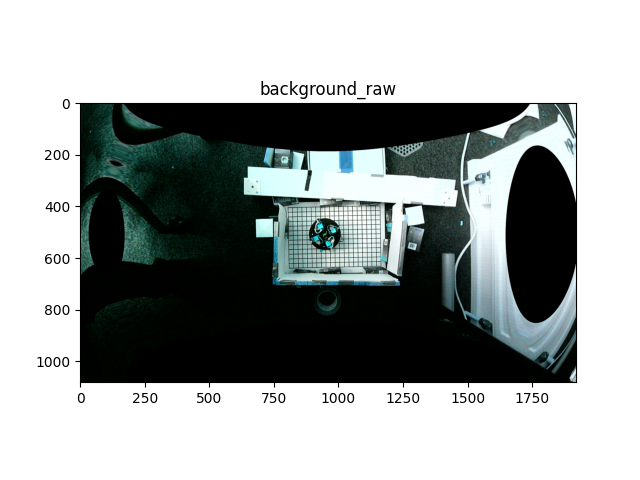

In [4]:
%matplotlib ipympl
avgiter=5
# take_pic(cam,avgiter)
background_raw = take_pic_undist(cam,avgiter,matrix,distortion,newcameramtx)
# nb_show("raw background",cv2.cvtColor(background_raw, cv2.COLOR_RGB2BGR))
cv2.imwrite('./content/background.jpg',background_raw)
nb_show("background_raw",background_raw)

Here you have to crop manually the image to fit perfectly the grid 

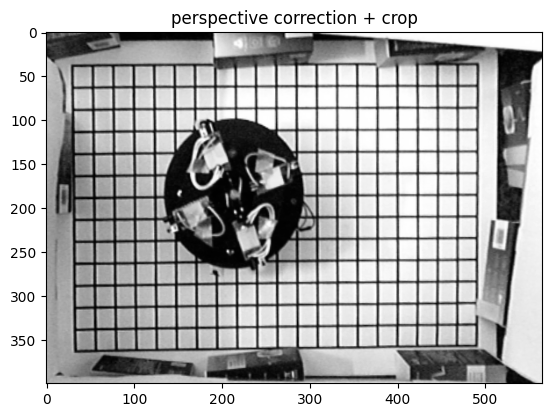

In [6]:
%matplotlib inline
src = np.float32([(782,377),(784,666),(1225,662),(1218,370)]) # top right, bottom right, bottom left, top left 
h = 400
w = 400 * math.sqrt(2)
dst = np.float32([[0,0],[0,h],[w,h],[w,0]])
M = cv2.getPerspectiveTransform(src, dst)


paper_sheet = np.zeros((int(w),int(h)), dtype=np.uint8)
background = cv2.warpPerspective(background_raw, M, paper_sheet.shape)
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

nb_show("perspective correction + crop",background)

GRID SHAPE : (21, 17, 2)


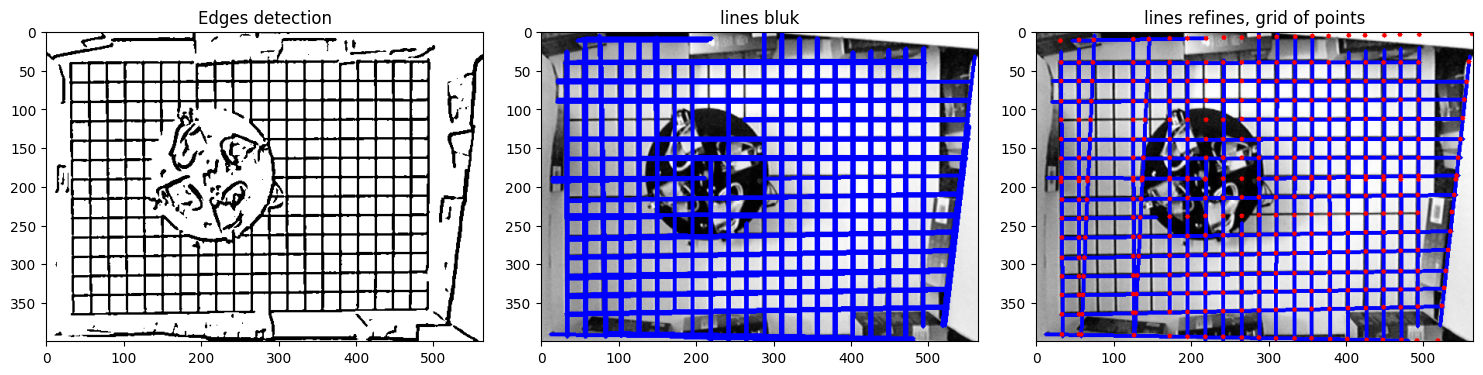

In [7]:
%matplotlib inline

edges = processing_background(background)

# Create HoughBundler instance to process lines given by cv2.HoughLinesP()
bundler = HoughBundler(min_distance=20,min_angle=5)
#background_processed = bundler.preprocessing(background)
lines_bulk = cv2.HoughLinesP(cv2.bitwise_not(edges),rho = 1,theta = 1*np.pi/180,threshold = 150,minLineLength = 100,maxLineGap = 50)
lines = bundler.process_lines(lines_bulk)

# Convert processed lines to a point matrix
points_matrix_unsorted = lines_to_grid(lines)
i = 0
points_matrix_sorted = points_matrix_unsorted
for row in points_matrix_unsorted:
    prod = row[row[:, 0].argsort()]
    points_matrix_sorted[i][:] = prod
    i = i+1

points_matrix = np.transpose(points_matrix_sorted,(1,0,2))

img_out_lines = cv2.cvtColor(background.copy(),cv2.COLOR_GRAY2RGB)
for line in lines_bulk:
    cv2.line(img_out_lines,(line[0][0],line[0][1]),(line[0][2],line[0][3]),(0,0,255),3)

img_out_1 = cv2.cvtColor(background.copy(),cv2.COLOR_GRAY2RGB)
for line in lines:
    cv2.line(img_out_1,(line[0][0],line[0][1]),(line[0][2],line[0][3]),(0,0,255),3)
for i in range(points_matrix.shape[0]):
  for j in range(points_matrix.shape[1]):
    cv2.circle(img_out_1, points_matrix[i][j][:] , radius=3, color=(255, 0, 0), thickness=-1)

print("GRID SHAPE :",points_matrix.shape)
nb_show_n([ "Edges detection", "lines bluk","lines refines, grid of points"],[edges, img_out_lines,img_out_1])

Background image has been processed, and grid points have been extracted. 

# Actual measuring loop :

Now, turn the spiderino ON. Place it on the grid. Plug ESP8266 receiver to PC and listen on serial monitor via serial_read.ipnyb
* At every iteration of the loop, the script tries to locate green and red LEDs to compute Spiderino position and angle.
* Then, as the boundaries positions are known, theoretical distances to the wall seen by the sensors are computed.
* Finally, computed values are stored with measured values in a csv file.

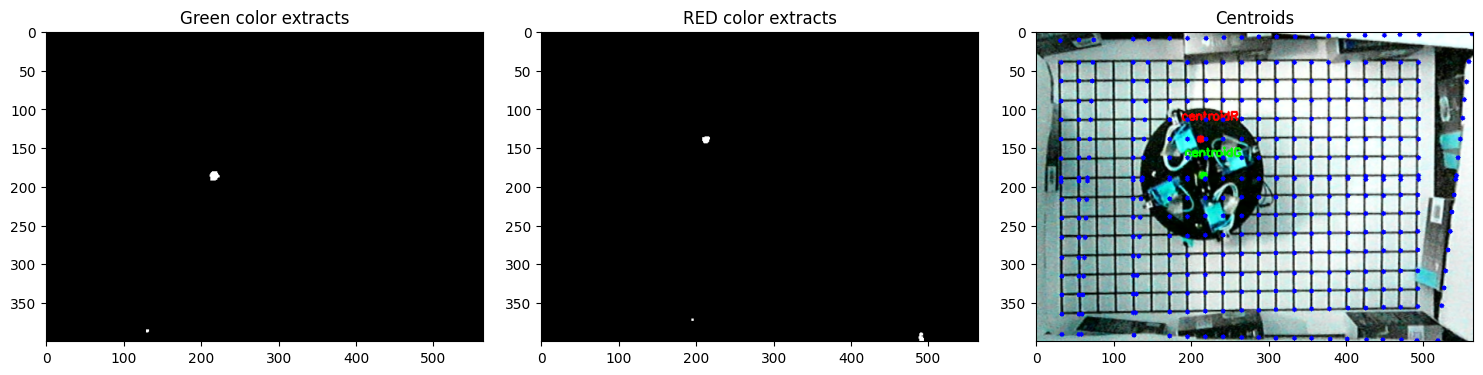

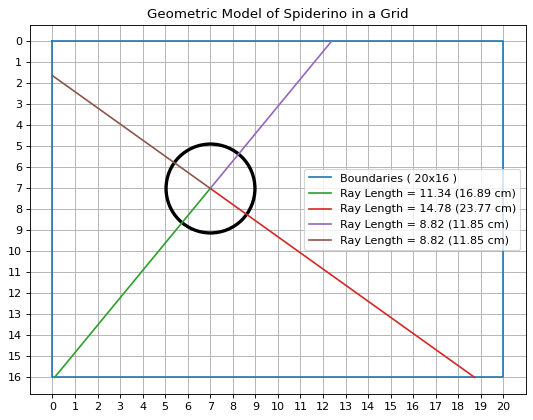

SystemExit: 0

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
import serial
from IPython.display import clear_output
import time
import sys, signal
def signal_handler(signal, frame):

    sys.exit(0)

header = ["IR0_meas", "IR1_meas", "IR2_meas", "IR3_meas"]


grid_cm_ratio = 2 # 1 unit on grid = 3cm
sensor_center_distance = 5.8 # sensors are placed {sensor_placement} cm from center
avgiter=5
# fig = plt.figure(figsize=(8, 6), dpi=80)


fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)



try :
  while True :
    signal.signal(signal.SIGINT, signal_handler)
    frame_raw = take_pic_undist(cam,1,matrix,distortion,newcameramtx)
    frame_color = cv2.warpPerspective(frame_raw, M, paper_sheet.shape)
    cv2.imwrite('./content/frame.jpg',frame_color)
    try :
        spiderino, grid, real_rays, spiderino_centroid = rays_calculations(frame_color, grid_cm_ratio ,sensor_center_distance, points_matrix, lines)
    except :
        print("centroids not found")
        pass

    add_data_to_csv(features_path = "./content/measures.csv",labels_vect = real_rays,output_path = './content/merge-2811.csv')
    
    plotos(spiderino_centroid, spiderino, grid, grid_cm_ratio,real_rays,sensor_center_distance)


    # ax.cla()
    # plt.plot(*grid.boundaries.xy, label="Boundaries ( "+ str(grid.x_max) +"x"+ str(grid.y_max) +" )")
    # plt.plot(*spiderino.pos.xy, marker="o", markersize=80, markeredgecolor="black", markerfacecolor="none", markeredgewidth=3)
    # i=0
    # for sensor in spiderino.sensors_array :
    #     plt.plot(*sensor.ray.xy, label="Ray Length = " + str(round((sensor.ray.length),2)) +" (" +str(real_rays[i])+" cm)")
    #     i=i+1
    # leg = plt.legend()
    # ax.set_xticks(np.arange(0,grid.x_max+1))
    # ax.set_yticks(np.arange(0,grid.y_max+1))
    # plt.gca().invert_yaxis()
    # plt.grid(True)
    # ax.title.set_text("Geometric Model of Spiderino in a Grid")
    # # ax.invert_yaxis()
    # display(fig)
    # # clear_output(wait = True)


    time.sleep(0.5)
    clear_output(wait=True)

except KeyboardInterrupt:
    print("interrupt")
    pass

